In [1]:
import matplotlib.pyplot as plt
import json

with open('../results/transformer/scan/addjump/train_defaults_jump0.json', 'r') as f:
    transformer_res = json.load(f)

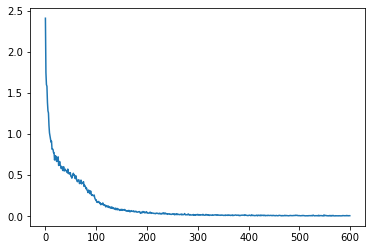

In [2]:
plt.plot(transformer_res['loss_data'])

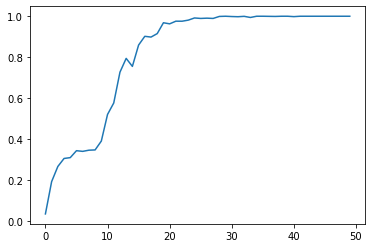

In [3]:
plt.plot(transformer_res['train_accs'])

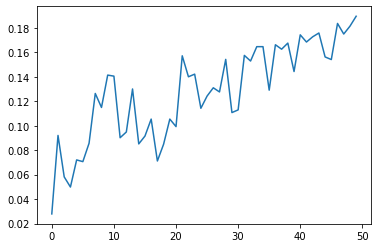

In [4]:
plt.plot(transformer_res['test_accs'])

In [5]:
with open('../results/language_parser/scan/addjump/train_defaults_jump0.json', 'r') as f:
    lp_res = json.load(f)

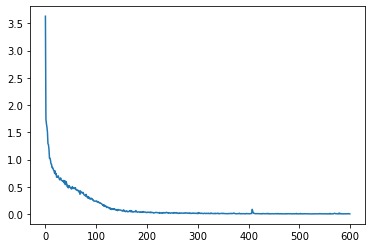

In [6]:
plt.plot(lp_res['loss_data'])

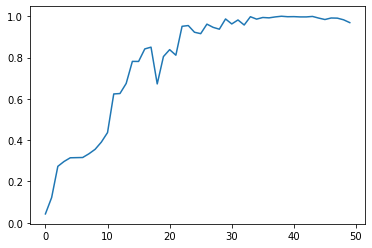

In [7]:
plt.plot(lp_res['train_accs'])

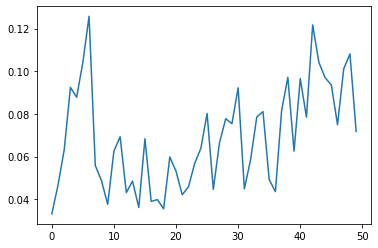

In [8]:
plt.plot(lp_res['test_accs'])

In [9]:
with open('../results/sep-transformer/scan/addjump/train_sep_enc_jump0.json', 'r') as f:
    st_res = json.load(f)

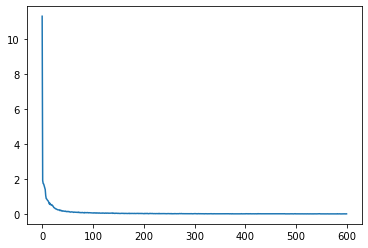

In [10]:
plt.plot(st_res['loss_data'])

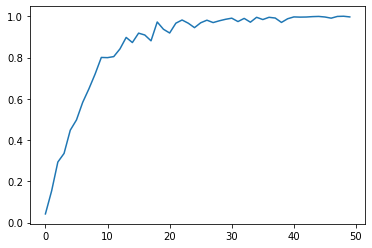

In [11]:
plt.plot(st_res['train_accs'])

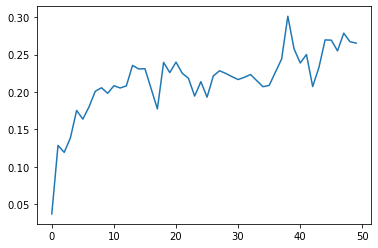

In [12]:
plt.plot(st_res['test_accs'])

In [13]:
with open('../results/sep-transformer/scan/addjump/train_sep_enc_se_jump0.json', 'r') as f:
    se_res = json.load(f)

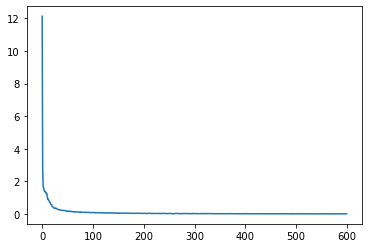

In [14]:
plt.plot(se_res['loss_data'])

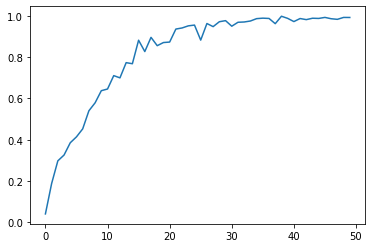

In [15]:
plt.plot(se_res['train_accs'])

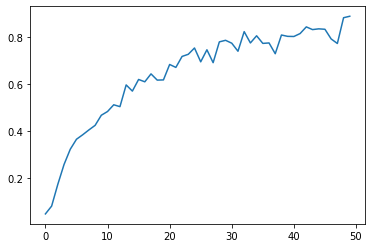

In [16]:
plt.plot(se_res['test_accs'])

In [17]:
from data import build_scan
import torch
import numpy as np
SRC, TRG, data, pos_data = build_scan(split='addjump', batch_size=64, device='cpu', use_pos=False)

In [18]:
src_txt = ['<sos> jump left <eos>', '<sos> walk left <eos>', '<sos> jump twice <eos>', '<sos> walk twice <eos>', '<sos> jump opposite left <eos>', '<sos> walk opposite left <eos>', '<sos> jump around left <eos>', '<sos> walk around left <eos>', '<sos> turn around right and jump around right twice <eos>', '<sos> turn around right and walk around right twice <eos>', '<sos> jump opposite right twice after jump left twice <eos>', '<sos> walk opposite right twice after walk left twice <eos>']

In [19]:
ss = []
for s in src_txt:
    ss.append(s.split())

In [20]:
# For now, will have to do it sequentially, in pairs of two
src = []
for s in src_txt:
    l = []
    count = 0
    for w in s.split():
        l.append(SRC.vocab.stoi[w])
        count += 1
    while count < 10:
        l.append(1)
        count += 1
    src.append(l)
src = torch.from_numpy(np.array(src, dtype=int))
src

tensor([[ 2, 16,  5,  3,  1,  1,  1,  1,  1,  1],
        [ 2, 10,  5,  3,  1,  1,  1,  1,  1,  1],
        [ 2, 16,  6,  3,  1,  1,  1,  1,  1,  1],
        [ 2, 10,  6,  3,  1,  1,  1,  1,  1,  1],
        [ 2, 16,  9,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 10,  9,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 16,  8,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 10,  8,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 15,  8,  4, 14, 16,  8,  4,  6,  3],
        [ 2, 15,  8,  4, 14, 10,  8,  4,  6,  3],
        [ 2, 16,  9,  4,  6, 13, 16,  5,  6,  3],
        [ 2, 10,  9,  4,  6, 13, 10,  5,  6,  3]])

In [21]:
trg_txt = ['<sos> I_TURN_LEFT I_JUMP <eos>', '<sos> I_TURN_LEFT I_WALK <eos>', '<sos> I_JUMP I_JUMP <eos>', '<sos> I_WALK I_WALK <eos>', '<sos> I_TURN_LEFT I_TURN_LEFT I_JUMP <eos>', '<sos> I_TURN_LEFT I_TURN_LEFT I_WALK <eos>', '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <eos>', '<sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <eos>', '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <eos>', '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <eos>', '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <eos>', '<sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <eos>']

In [22]:
tt = []
for t in trg_txt:
    tt.append(t.split())

In [23]:
# For now, will have to do it sequentially, in pairs of two
trg = []
for s in trg_txt:
    l = []
    count = 0
    for w in s.split():
        l.append(TRG.vocab.stoi[w])
        count += 1
    while count < 23:
        l.append(1)
        count += 1
    trg.append(l)
trg = torch.from_numpy(np.array(trg, dtype=int))
trg

tensor([[2, 5, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 9, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 6, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 5, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 5, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 9, 5, 9, 5, 9, 5, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 6, 5, 6, 5, 6, 5, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 4, 4, 4, 4, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 3, 1],
        [2, 4, 4, 4, 4, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 3, 1],
        [2, 5, 9, 5, 9, 4, 4, 9, 4, 4, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 6, 5, 6, 4, 4, 6, 4, 4, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [24]:
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

def draw(data, x, y, ax):
    colormap = seaborn.color_palette("Greens")
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=True, cbar_kws={"shrink": 0.5}, cmap=colormap, ax=ax)

Transformer Attention Visualizations

In [25]:
import torch
from models.models import Transformer
model = Transformer(
    src_vocab_size=17,
    trg_vocab_size=10,
    d_model=256,
    nhead=8,
    n_layers=2,
    dim_feedforward=512,
    dropout=0.1,
    pad_idx=1,
    device=torch.device('cpu')
)
device = torch.device('cpu')
model.load_state_dict(torch.load('../weights/transformer/scan/defaults_addjump.pt', map_location=device))
model.device = 'cpu'

In [26]:
pad_idx = 1
model.eval()
all_correct_trials = []
with torch.no_grad():
    trg_input = trg[:, :-1]
    trg_out = trg[:, 1:]
    out, attn_wt = model(src, trg_input)
    pred = torch.argmax(out, axis=2)
    correct_pred = pred == trg_out
    correct_pred = correct_pred.cpu().numpy()
    mask = trg_out == pad_idx
    mask = mask.cpu().numpy()
    correct = np.logical_or(mask, correct_pred)
    correct = correct.all(0).tolist()
    all_correct_trials += correct
print(np.mean(all_correct_trials))

0.36363636363636365


In [27]:
predictions = []
preds_txt = []
for s in pred:
    prediction = '<sos> '
    for i in range(1, s.shape[0]):
        sym = TRG.vocab.itos[s[i]]
        if sym == '<eos>': break
        prediction += sym + ' '
    prediction += '<eos>'
    predictions.append(prediction.split())
    preds_txt.append(prediction)

In [28]:
trg_txt

['<sos> I_TURN_LEFT I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_WALK <eos>',
 '<sos> I_JUMP I_JUMP <eos>',
 '<sos> I_WALK I_WALK <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_WALK <eos>',
 '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <eos>',
 '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <eos>',
 '<sos> I_TURN_L

In [29]:
preds_txt

['<sos> I_LOOK <eos>',
 '<sos> I_WALK <eos>',
 '<sos> <eos>',
 '<sos> I_WALK <eos>',
 '<sos> I_TURN_LEFT I_LOOK <eos>',
 '<sos> I_TURN_LEFT I_WALK <eos>',
 '<sos> I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_LOOK <eos>',
 '<sos> I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <eos>',
 '<sos> I_LOOK I_LOOK I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <eos>',
 '<sos> I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <eos>']

Encoder Layer 1


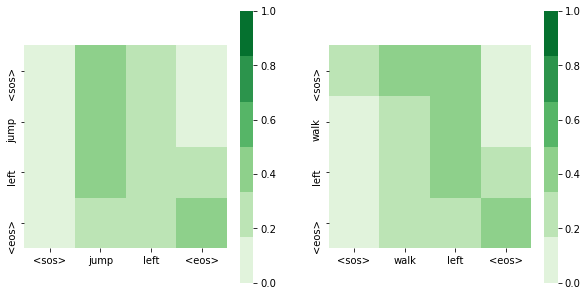

Encoder Layer 2


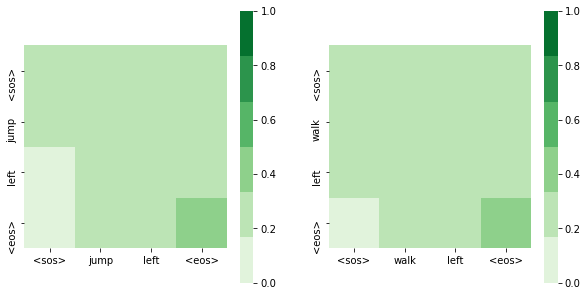

In [30]:
for layer in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Encoder Layer {layer + 1}")
    for i in range(2):
        draw(attn_wt.get('Encoder')[layer][i][:len(ss[i]), :len(ss[i])], ss[i], ss[i], ax=axs[i])
    plt.show()

Decoder Self Attention Layer 1


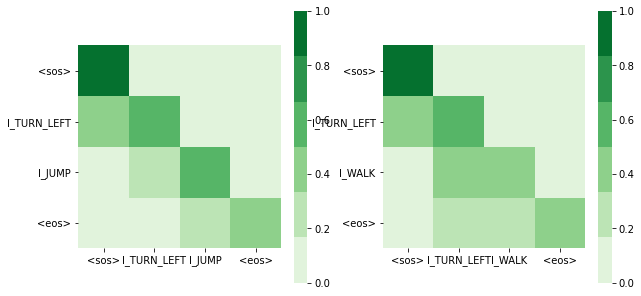

Decoder Self Attention Layer 2


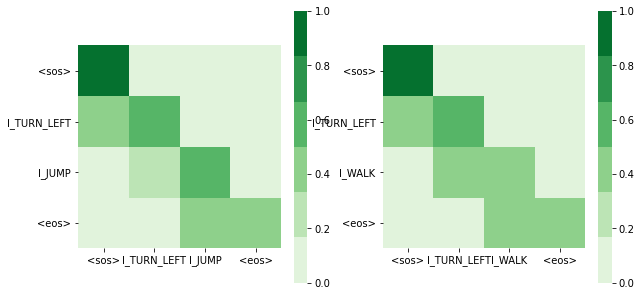

In [31]:
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Decoder Self Attention Layer {layer + 1}")
    for i in range(2):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer1')[i][:len(tt[i]), :len(tt[i])], 
             tt[i], tt[i], ax=axs[i])
    plt.show()

Decoder MHA Layer 1


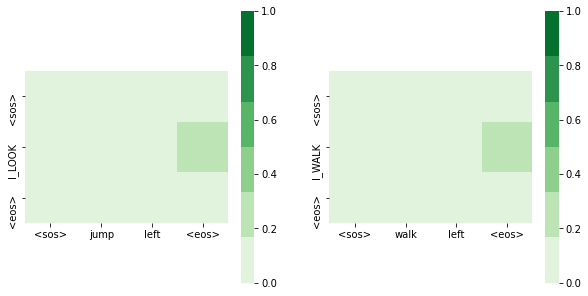

<sos> I_TURN_LEFT I_JUMP <eos> 	 <sos> I_TURN_LEFT I_WALK <eos>
Decoder MHA Layer 2


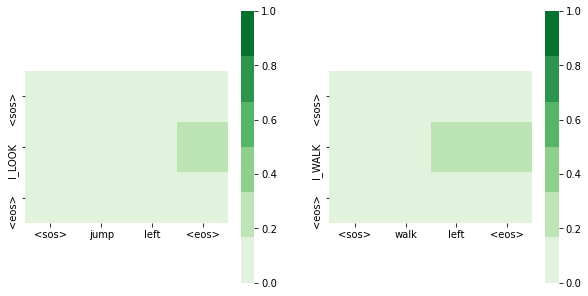

<sos> I_TURN_LEFT I_JUMP <eos> 	 <sos> I_TURN_LEFT I_WALK <eos>


In [32]:
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Decoder MHA Layer {layer + 1}")
    for i in range(2):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer2')[i][:len(predictions[i]), :len(ss[i])],
             ss[i], predictions[i], ax=axs[i])
    plt.show()
    print(trg_txt[0], '\t', trg_txt[1])

Encoder Layer 1


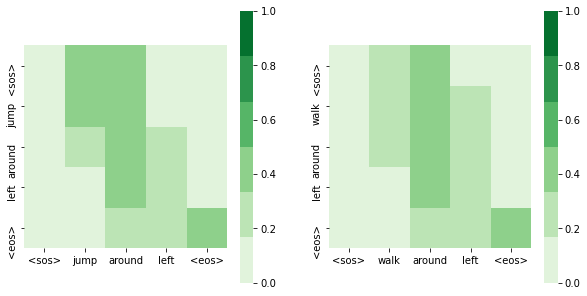

Encoder Layer 2


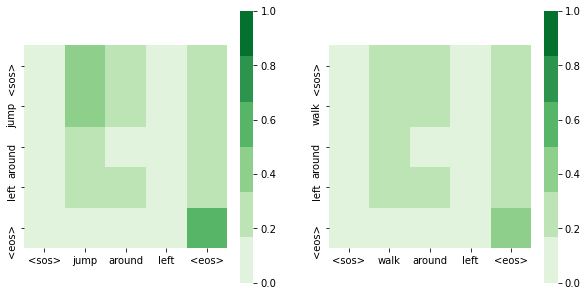

In [33]:
for layer in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Encoder Layer {layer + 1}")
    for i in range(6, 8):
        draw(attn_wt.get('Encoder')[layer][i][:len(ss[i]), :len(ss[i])], ss[i], ss[i], ax=axs[i-6])
    plt.show()

Decoder Self Attention Layer 1


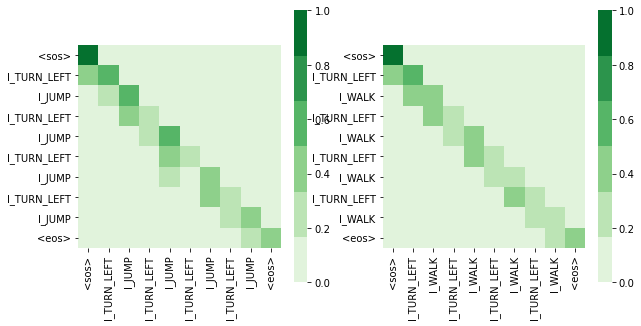

Decoder Self Attention Layer 2


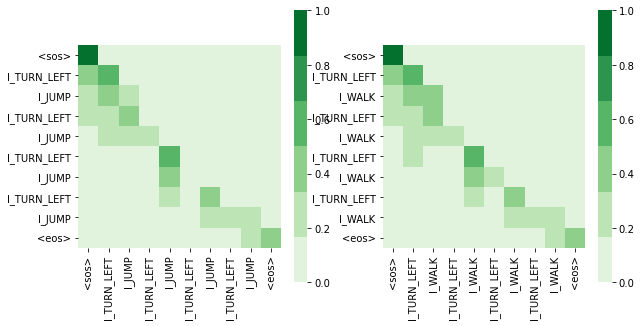

In [34]:
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Decoder Self Attention Layer {layer + 1}")
    for i in range(6, 8):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer1')[i][:len(tt[i]), :len(tt[i])], 
             tt[i], tt[i], ax=axs[i-6])
    plt.show()

Decoder MHA Layer 1


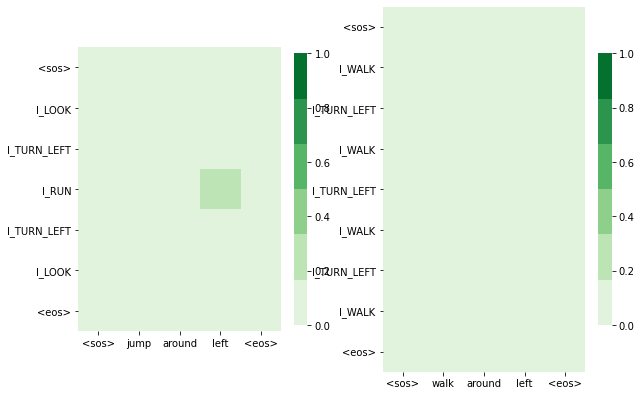

<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <eos> 	 <sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <eos>
Decoder MHA Layer 2


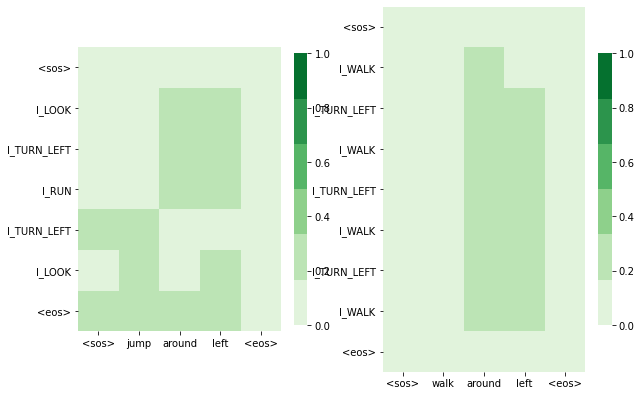

<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <eos> 	 <sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <eos>


In [35]:
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Decoder MHA Layer {layer + 1}")
    for i in range(6, 8):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer2')[i][:len(predictions[i]), :len(ss[i])],
             ss[i], predictions[i], ax=axs[i-6])
    plt.show()
    print(trg_txt[6], '\t', trg_txt[7])

Encoder Layer 1


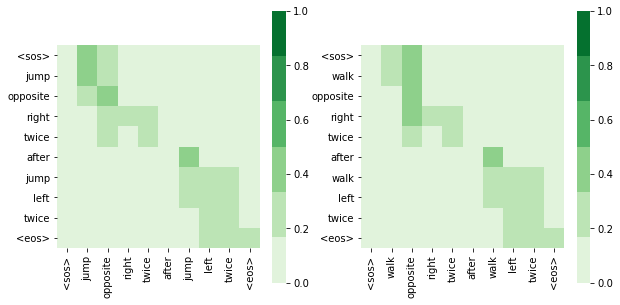

Encoder Layer 2


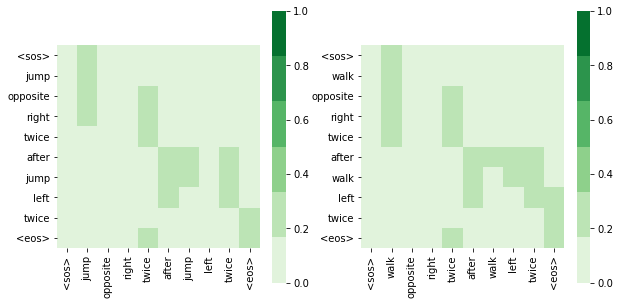

In [36]:
for layer in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Encoder Layer {layer + 1}")
    for i in range(10, 12):
        draw(attn_wt.get('Encoder')[layer][i][:len(ss[i]), :len(ss[i])], ss[i], ss[i], ax=axs[i-10])
    plt.show()

Decoder Self Attention Layer 1


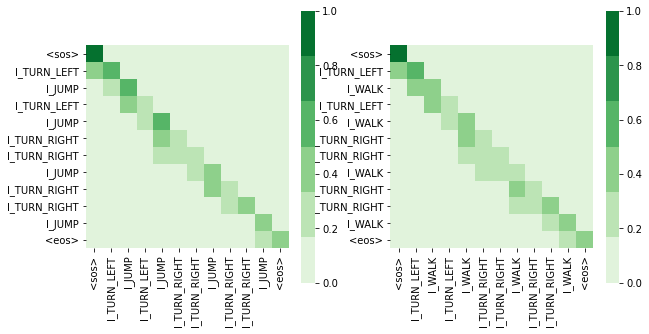

Decoder Self Attention Layer 2


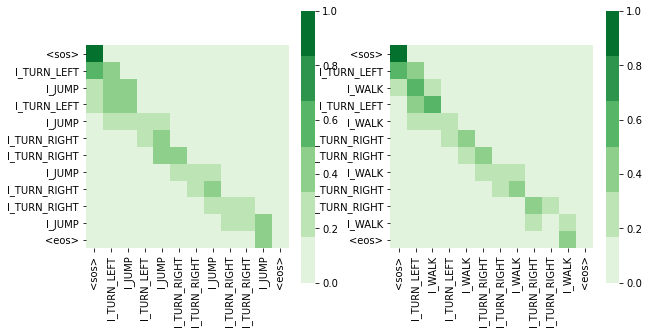

In [37]:
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Decoder Self Attention Layer {layer + 1}")
    for i in range(10, 12):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer1')[i][:len(tt[i]), :len(tt[i])], 
             tt[i], tt[i], ax=axs[i-10])
    plt.show()

Decoder MHA Layer 1


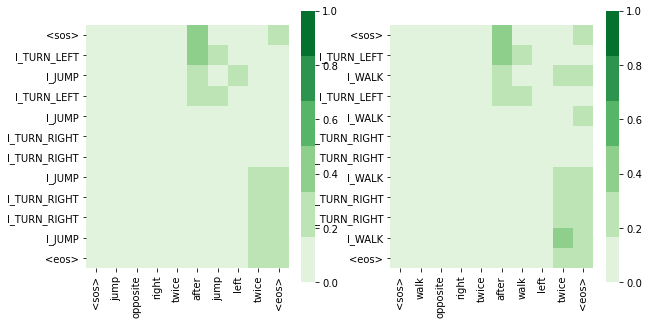

<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <eos> 	 <sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <eos>
Decoder MHA Layer 2


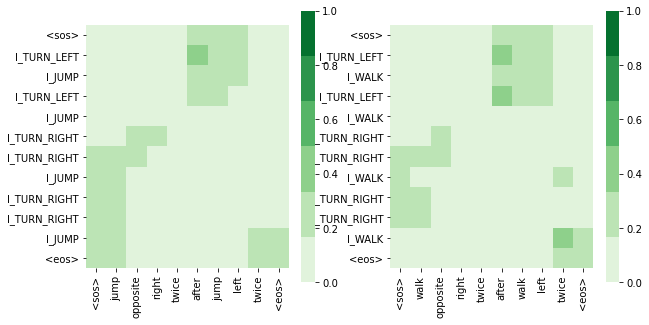

<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <eos> 	 <sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <eos>


In [38]:
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Decoder MHA Layer {layer + 1}")
    for i in range(10, 12):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer2')[i][:len(tt[i]), :len(ss[i])],
             ss[i], tt[i], ax=axs[i-10])
    plt.show()
    print(trg_txt[10], '\n', trg_txt[11])

Language Parser Analysis

In [39]:
import torch
from models.models import LanguageParser
model = LanguageParser(
    src_vocab_size=17,
    trg_vocab_size=10,
    d_model=256,
    nhead=8,
    n_layers=1,
    dim_feedforward=256,
    dropout=0.1,
    pad_idx=1,
    device=torch.device('cpu')
)
device = torch.device('cpu')
model.load_state_dict(torch.load('../weights/language_parser/scan/defaults_addjump.pt', map_location=device))
model.device = 'cpu'

In [40]:
pad_idx = 1
model.eval()
all_correct_trials = []
with torch.no_grad():
    trg_input = trg[:, :-1]
    trg_out = trg[:, 1:]
    out, attn_wt = model(src, trg_input)
    pred = torch.argmax(out, axis=2)
    correct_pred = pred == trg_out
    correct_pred = correct_pred.cpu().numpy()
    mask = trg_out == pad_idx
    mask = mask.cpu().numpy()
    correct = np.logical_or(mask, correct_pred)
    correct = correct.all(0).tolist()
    all_correct_trials += correct
print(np.mean(all_correct_trials))

0.3181818181818182


In [41]:
predictions = []
preds_txt = []
for s in pred:
    prediction = '<sos> '
    for i in range(1, s.shape[0]):
        sym = TRG.vocab.itos[s[i]]
        if sym == '<eos>': break
        prediction += sym + ' '
    prediction += '<eos>'
    predictions.append(prediction.split())
    preds_txt.append(prediction)

In [42]:
preds_txt

['<sos> I_WALK <eos>',
 '<sos> I_WALK <eos>',
 '<sos> I_WALK <eos>',
 '<sos> I_WALK <eos>',
 '<sos> I_TURN_LEFT I_RUN <eos>',
 '<sos> I_TURN_LEFT I_WALK <eos>',
 '<sos> I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_WALK I_WALK <eos>',
 '<sos> I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_LOOK <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT <eos>',
 '<sos> I_LOOK I_RUN I_RUN I_TURN_RIGHT I_RUN I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <eos>',
 '<sos> I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT <eos>']

In [43]:
trg_txt

['<sos> I_TURN_LEFT I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_WALK <eos>',
 '<sos> I_JUMP I_JUMP <eos>',
 '<sos> I_WALK I_WALK <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_WALK <eos>',
 '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <eos>',
 '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <eos>',
 '<sos> I_TURN_L

Stage 0, Block Encoder Attention Map, jump left all heads


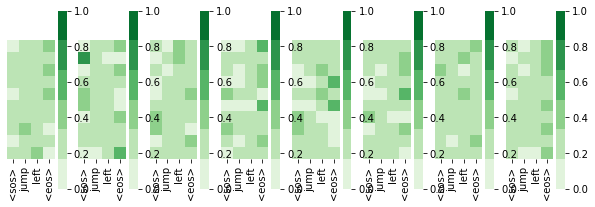

Stage 1, Block Encoder Attention Map, jump left all heads


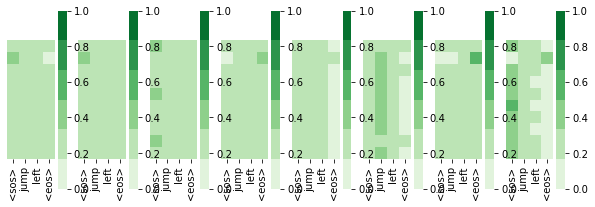

In [44]:
enc_maps = attn_wt.get('Encoder')
for s in range(0, 2):
    fig, axs = plt.subplots(1, 8, figsize=(10, 10))
    print(f"Stage {s}, Block Encoder Attention Map, jump left all heads")
    for h in range(8):
        draw(enc_maps[s][0].get('encoder')[:, :, h, :][0][:, :len(ss[0])], ss[0], [], ax=axs[h])
    plt.show()

Stage 0, Block Encoder Attention Map walk left all heads


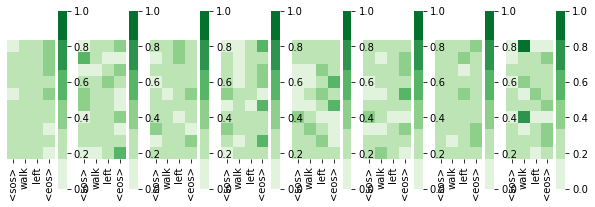

Stage 1, Block Encoder Attention Map walk left all heads


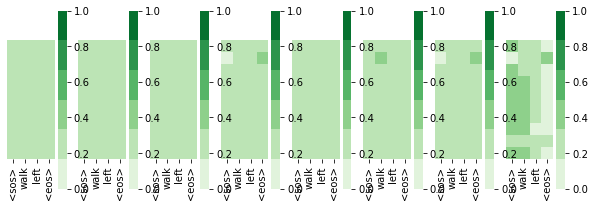

In [45]:
for s in range(0, 2):
    fig, axs = plt.subplots(1, 8, figsize=(10, 10))
    print(f"Stage {s}, Block Encoder Attention Map walk left all heads")
    for h in range(8):
        draw(enc_maps[s][0].get('encoder')[:, :, h, :][1][:, :len(ss[1])], ss[1], [], ax=axs[h])
    plt.show()

Stage 0, Block Encoder Attention Map


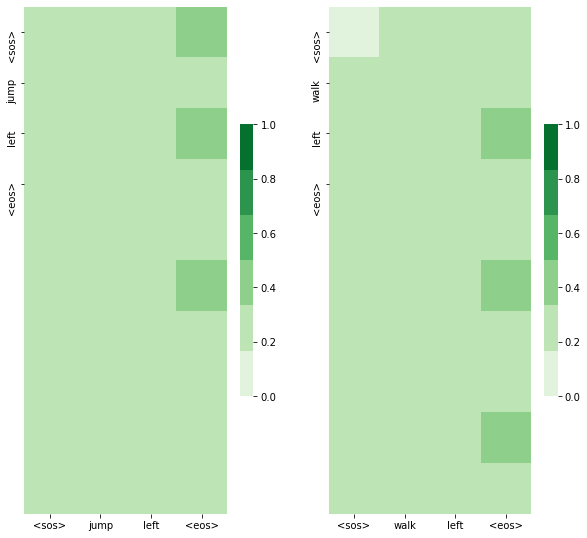

Stage 1, Block Encoder Attention Map


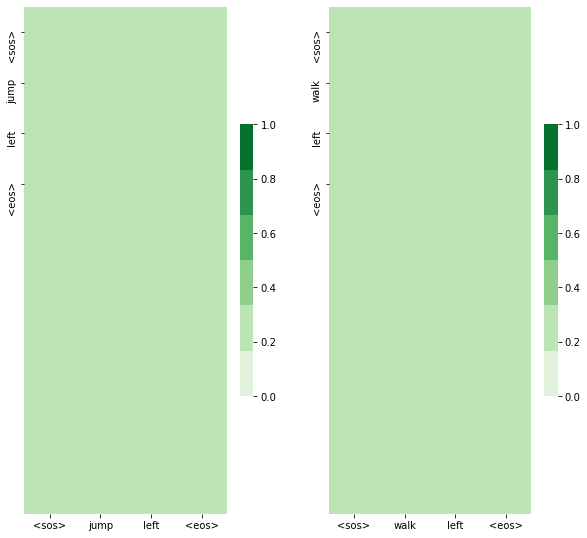

In [46]:
for s in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Stage {s}, Block Encoder Attention Map")
    for i in range(2):
        draw(torch.mean(enc_maps[s][0].get('encoder'), axis=2)[i][:, :len(ss[i])], ss[i], ss[i], ax=axs[i])
    plt.show()

Stage 0, Block Decoder MHA


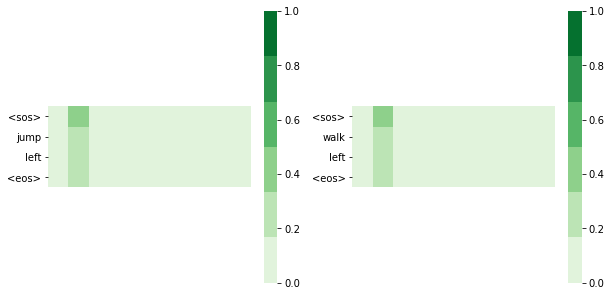

Stage 1, Block Decoder MHA


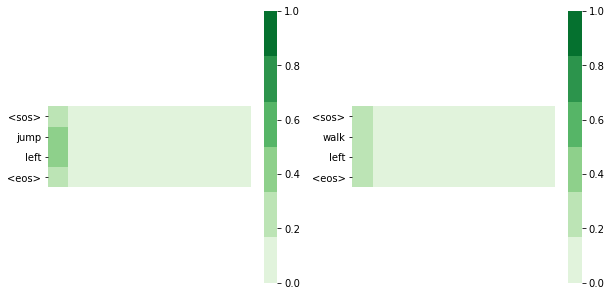

In [47]:
for s in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Stage {s}, Block Decoder MHA")
    for i in range(2):
        draw(torch.mean(enc_maps[s][0].get('decoder').get('MHA'), axis=2)[i][:len(ss[i]), :], [], ss[i], ax=axs[i])
    plt.show()

Stage 0, Block Decoder Self


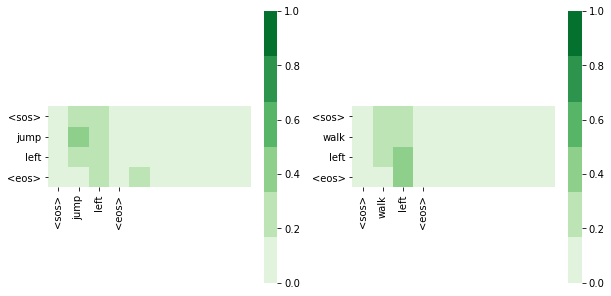

Stage 1, Block Decoder Self


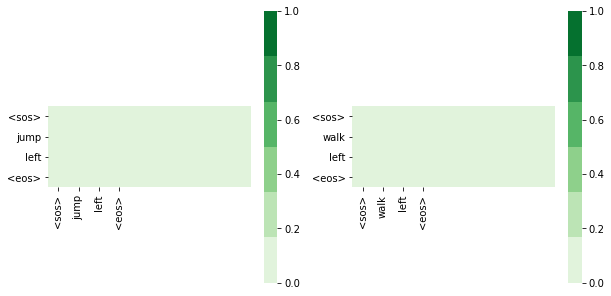

In [48]:
for s in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Stage {s}, Block Decoder Self")
    for i in range(2):
        draw(torch.mean(enc_maps[s][0].get('decoder').get('Self'), axis=2)[i][:len(ss[i]), :], ss[i], ss[i], ax=axs[i])
    plt.show()

Last Encoder Map


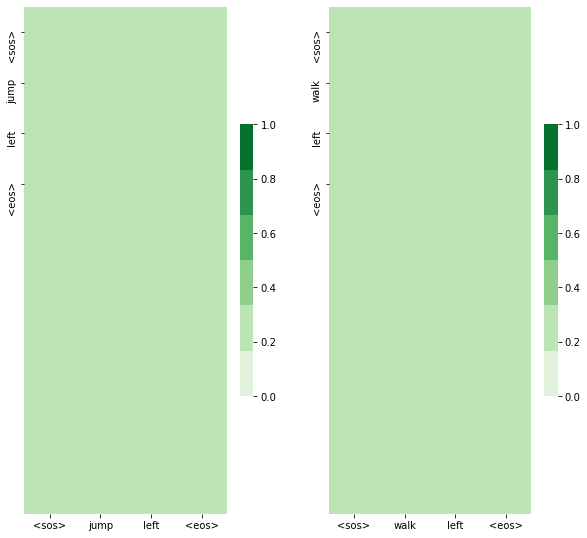

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
print(f"Last Encoder Map")
for i in range(2):
    draw(torch.mean(enc_maps[1][1], axis=2)[i][:, :len(ss[i])], ss[i], ss[i], ax=axs[i])

Decoeder Self Attention Layer 1


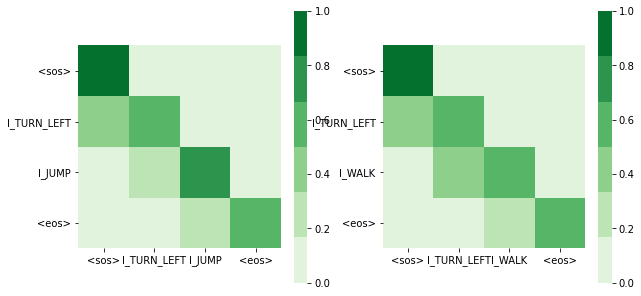

Decoeder Self Attention Layer 2


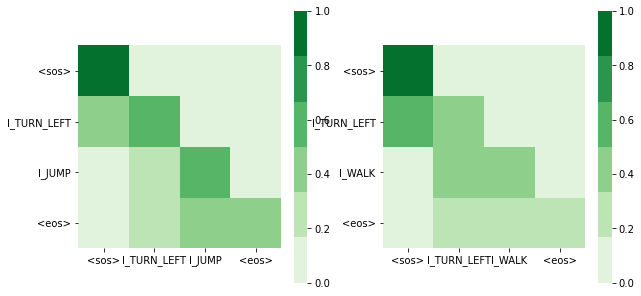

In [50]:
dec_maps = attn_wt.get('Decoder')
for layer in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f'Decoeder Self Attention Layer {layer + 1}')
    for i in range(2):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer1')[i][:len(tt[i]), :len(tt[i])], tt[i], tt[i], ax=axs[i])
    plt.show()

Decoeder Self Attention Layer 1


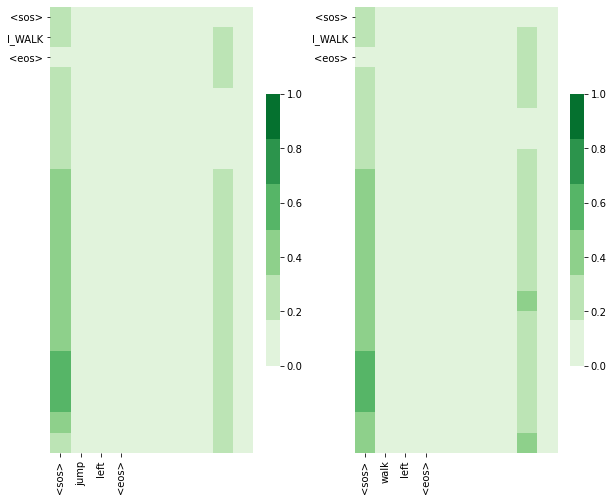

Decoeder Self Attention Layer 2


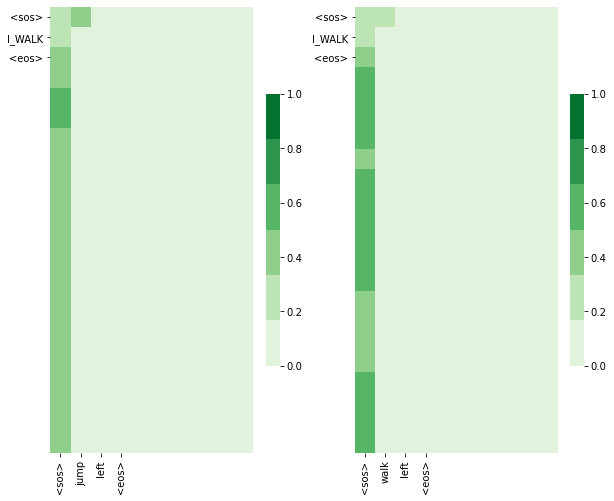

In [51]:
dec_maps = attn_wt.get('Decoder')
for layer in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f'Decoeder Self Attention Layer {layer + 1}')
    for i in range(2):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer2')[i], ss[i], predictions[i], ax=axs[i])
    plt.show()

Decoder MHA Attention Layer 1


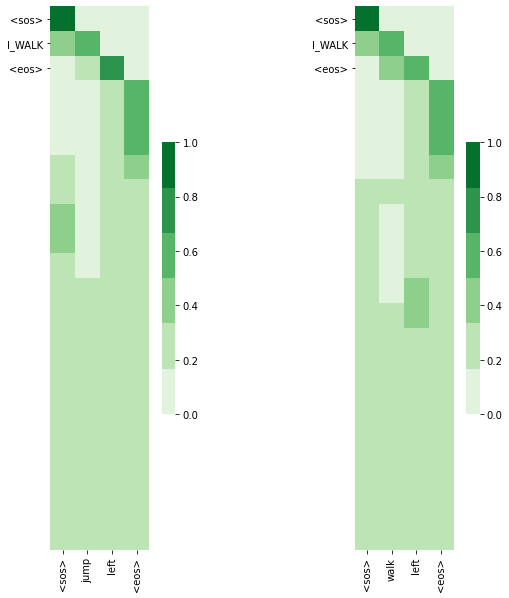

<sos> I_TURN_LEFT I_JUMP <eos> 	 <sos> I_TURN_LEFT I_WALK <eos>
Decoder MHA Attention Layer 2


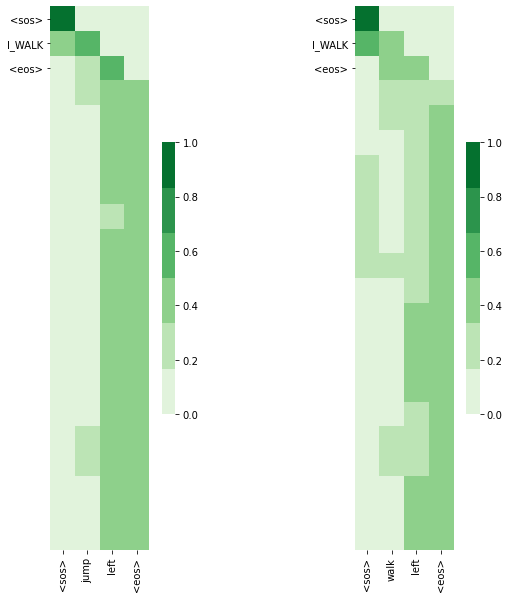

<sos> I_TURN_LEFT I_JUMP <eos> 	 <sos> I_TURN_LEFT I_WALK <eos>


In [52]:
for layer in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f'Decoder MHA Attention Layer {layer + 1}')
    for i in range(2):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer1')[i][:, :len(ss[i])], ss[i], predictions[i], ax=axs[i])
    plt.show()
    print(trg_txt[0], '\t', trg_txt[1])

Sep Transformer Analysis


In [53]:
src_txt = [
    '<sos> jump left <eos>', 
    '<sos> walk left <eos>', 
    '<sos> jump twice <eos>', 
    '<sos> walk twice <eos>', 
    '<sos> jump opposite left <eos>', 
    '<sos> walk opposite left <eos>',
    '<sos> jump around left <eos>', 
    '<sos> walk around left <eos>', 
    '<sos> turn around right and jump around right twice <eos>', 
    '<sos> turn around right and walk around right twice <eos>', 
    '<sos> jump opposite right twice after jump left twice <eos>', 
    '<sos> walk opposite right twice after walk left twice <eos>']
src_ann_txt = [
    '<sos> prim left <eos>', 
    '<sos> prim left <eos>', 
    '<sos> prim twice <eos>', 
    '<sos> prim twice <eos>', 
    '<sos> prim opposite left <eos>', 
    '<sos> prim opposite left <eos>',
    '<sos> prim around left <eos>', 
    '<sos> prim around left <eos>', 
    '<sos> turn around right and prim around right twice <eos>', 
    '<sos> turn around right and prim around right twice <eos>', 
    '<sos> prim opposite right twice after prim left twice <eos>', 
    '<sos> prim opposite right twice after prim left twice <eos>'
]

In [54]:
ss = []
ss_ann = []
for s, s_ann in zip(src_txt, src_ann_txt):
    ss.append(s.split())
    ss_ann.append(s_ann.split())

In [55]:
# For now, will have to do it sequentially, in pairs of two
src = []
src_ann = []
for s, s_ann in zip(src_txt, src_ann_txt):
    l = []
    m = []
    count = 0
    for w in s.split():
        l.append(SRC.vocab.stoi[w])
        count += 1
    for v in s_ann.split():
        m.append(SRC.vocab.stoi[v])
    while count < 10:
        l.append(1)
        m.append(1)
        count += 1
    src.append(l)
    src_ann.append(m)
src = torch.from_numpy(np.array(src, dtype=int))
src_ann = torch.from_numpy(np.array(src_ann, dtype=int))
print(src)
print(src_ann)

tensor([[ 2, 16,  5,  3,  1,  1,  1,  1,  1,  1],
        [ 2, 10,  5,  3,  1,  1,  1,  1,  1,  1],
        [ 2, 16,  6,  3,  1,  1,  1,  1,  1,  1],
        [ 2, 10,  6,  3,  1,  1,  1,  1,  1,  1],
        [ 2, 16,  9,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 10,  9,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 16,  8,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 10,  8,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 15,  8,  4, 14, 16,  8,  4,  6,  3],
        [ 2, 15,  8,  4, 14, 10,  8,  4,  6,  3],
        [ 2, 16,  9,  4,  6, 13, 16,  5,  6,  3],
        [ 2, 10,  9,  4,  6, 13, 10,  5,  6,  3]])
tensor([[ 2,  0,  5,  3,  1,  1,  1,  1,  1,  1],
        [ 2,  0,  5,  3,  1,  1,  1,  1,  1,  1],
        [ 2,  0,  6,  3,  1,  1,  1,  1,  1,  1],
        [ 2,  0,  6,  3,  1,  1,  1,  1,  1,  1],
        [ 2,  0,  9,  5,  3,  1,  1,  1,  1,  1],
        [ 2,  0,  9,  5,  3,  1,  1,  1,  1,  1],
        [ 2,  0,  8,  5,  3,  1,  1,  1,  1,  1],
        [ 2,  0,  8,  5,  3,  1,  1,  1,  1,  1],

In [56]:
trg_txt = [
    '<sos> I_TURN_LEFT I_JUMP <eos>', 
    '<sos> I_TURN_LEFT I_WALK <eos>', 
    '<sos> I_JUMP I_JUMP <eos>', 
    '<sos> I_WALK I_WALK <eos>', 
    '<sos> I_TURN_LEFT I_TURN_LEFT I_JUMP <eos>', 
    '<sos> I_TURN_LEFT I_TURN_LEFT I_WALK <eos>', 
    '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <eos>', 
    '<sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <eos>', 
    '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <eos>', 
    '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <eos>', 
    '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <eos>',
    '<sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <eos>']
trg_ann_txt = [
    '<sos> I_TURN_LEFT PRIM <eos>', 
    '<sos> I_TURN_LEFT PRIM <eos>', 
    '<sos> PRIM PRIM <eos>', 
    '<sos> PRIM PRIM <eos>', 
    '<sos> I_TURN_LEFT I_TURN_LEFT PRIM <eos>', 
    '<sos> I_TURN_LEFT I_TURN_LEFT PRIM <eos>', 
    '<sos> I_TURN_LEFT PRIM I_TURN_LEFT PRIM I_TURN_LEFT PRIM I_TURN_LEFT PRIM <eos>', 
    '<sos> I_TURN_LEFT PRIM I_TURN_LEFT PRIM I_TURN_LEFT PRIM I_TURN_LEFT PRIM <eos>', 
    '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM <eos>', 
    '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM I_TURN_RIGHT PRIM <eos>', 
    '<sos> I_TURN_LEFT PRIM I_TURN_LEFT PRIM I_TURN_RIGHT I_TURN_RIGHT PRIM I_TURN_RIGHT I_TURN_RIGHT PRIM <eos>',
    '<sos> I_TURN_LEFT PRIM I_TURN_LEFT PRIM I_TURN_RIGHT I_TURN_RIGHT PRIM I_TURN_RIGHT I_TURN_RIGHT PRIM <eos>'
]

In [57]:
tt = []
tt_ann = []
for t, t_ann in zip(trg_txt, trg_ann_txt):
    tt.append(t.split())
    tt_ann.append(t_ann.split())

In [58]:
# For now, will have to do it sequentially, in pairs of two
trg = []
trg_ann = []
for s, t in zip(trg_txt, trg_ann_txt):
    l = []
    m = []
    count = 0
    for w in s.split():
        l.append(TRG.vocab.stoi[w])
        count += 1
    for v in t.split():
        m.append(TRG.vocab.stoi[v])
    while count < 23:
        l.append(1)
        m.append(1)
        count += 1
    trg.append(l)
    trg_ann.append(m)
trg = torch.from_numpy(np.array(trg, dtype=int))
trg_ann = torch.from_numpy(np.array(trg_ann, dtype=int))
print(trg)
print(trg_ann)

tensor([[2, 5, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 9, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 6, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 5, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 5, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 9, 5, 9, 5, 9, 5, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 6, 5, 6, 5, 6, 5, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 4, 4, 4, 4, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 3, 1],
        [2, 4, 4, 4, 4, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 3, 1],
        [2, 5, 9, 5, 9, 4, 4, 9, 4, 4, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 6, 5, 6, 4, 4, 6, 4, 4, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[2, 5, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [59]:
import torch
from models.tp_separate import EmbeddingMultilinearSinusoidal, Encoder, Decoder, Seq2Seq

embedding = EmbeddingMultilinearSinusoidal(d_vocab=18,
                                           d_x=256,
                                           d_r=256//8,
                                           dropout=0.1,
                                           max_length=200)
encoder = Encoder(
    d_x=256,
    d_q=256//8,
    d_k=256//8,
    d_v=256//8,
    d_f=512,
    n_I=8,
    n_L=2,
    use_xv=False,
    dropout=0.1
)
decoder = Decoder(
    d_x=256,
    d_q=256//8,
    d_k=256//8,
    d_v=256//8,
    d_f=512,
    use_xv=False,
    cat_xm=False,
    n_I=8,
    n_L=2,
    dropout=0.1
)

model = Seq2Seq(embedding=embedding,
               encoder=encoder,
               decoder=decoder,
               pad_idx=1,
               use_adversary=False,
               d_x=256,
               d_vocab=18,
               adv_lambda=0.01,
               adv_theta=0.01,
               adv_lr=0.01,
               skip_enc=False)

device = torch.device('cpu')
model.load_state_dict(torch.load('../weights/sep-transformer/scan/defaults_sep_enc_addjump.pt', map_location=device))
model = model.to(device)

In [60]:
pad_idx = 1
model.eval()
all_correct_trials = []
with torch.no_grad():
    trg_input = trg[:, :-1]
    trg_out = trg[:, 1:]
    trg_ann_input = trg_ann[:, :-1]
    out, adv_stat, attn_wt = model(src, trg_input, src_ann, trg_ann_input)
    pred = torch.argmax(out, axis=2)
    correct_pred = pred == trg_out
    correct_pred = correct_pred.cpu().numpy()
    mask = trg_out == pad_idx
    mask = mask.cpu().numpy()
    correct = np.logical_or(mask, correct_pred)
    correct = correct.all(0).tolist()
    all_correct_trials += correct
print(np.mean(all_correct_trials))

0.09090909090909091


In [61]:
predictions = []
preds_txt = []
for s in pred:
    prediction = '<sos> '
    for i in range(1, s.shape[0]):
        sym = TRG.vocab.itos[s[i]]
        if sym == '<eos>': break
        prediction += sym + ' '
    prediction += '<eos>'
    predictions.append(prediction.split())
    preds_txt.append(prediction)

In [62]:
preds_txt

['<sos> I_JUMP <eos>',
 '<sos> I_TURN_LEFT <eos>',
 '<sos> I_JUMP I_JUMP I_JUMP <eos>',
 '<sos> I_WALK I_WALK <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_RUN I_RUN I_RUN I_RUN <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_RUN <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_TURN_RIGHT I_LOOK I_WALK I_LOOK I_LOOK I_WALK I_LOOK I_LOOK <eos>']

In [63]:
trg_txt

['<sos> I_TURN_LEFT I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_WALK <eos>',
 '<sos> I_JUMP I_JUMP <eos>',
 '<sos> I_WALK I_WALK <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_WALK <eos>',
 '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <eos>',
 '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <eos>',
 '<sos> I_TURN_L

Encoder Layer 1


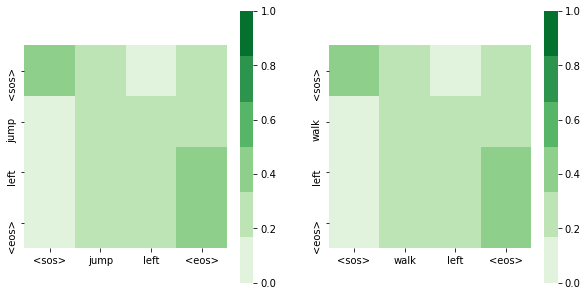

Encoder Layer 2


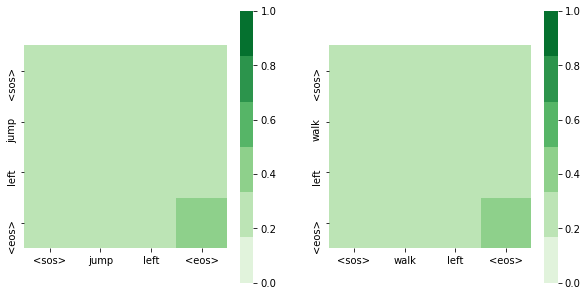

In [64]:
enc_maps = attn_wt.get('Encoder')
for layer in range(2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Encoder Layer {layer + 1}")
    for i in range(2):
        draw(torch.mean(attn_wt.get('Encoder')[layer][i], axis=0)[:len(ss[i]), :len(ss[i])], ss[i], ss[i], ax=axs[i])
    plt.show()

Decoder Layer 1 Self Attention


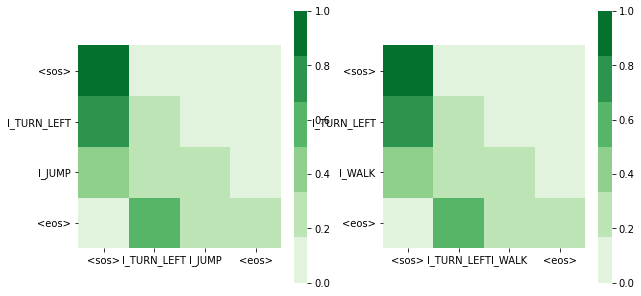

Decoder Layer 2 Self Attention


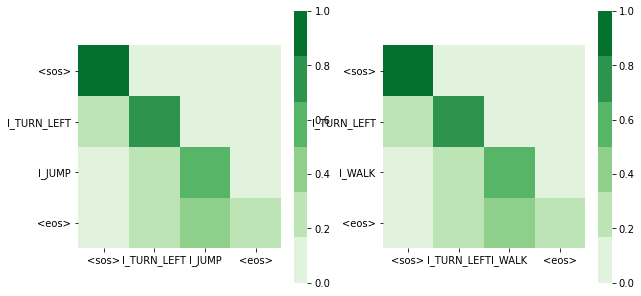

In [65]:
dec_maps = attn_wt.get('Decoder')
for layer in range(2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f'Decoder Layer {layer + 1} Self Attention')
    for i in range(2):
        draw(torch.mean(dec_maps[layer].get('Sublayer1')[i], axis=0)[:len(tt[i]), :len(tt[i])], tt[i], tt[i], ax=axs[i])
    plt.show()

Decoder Layer 1 Self Attention


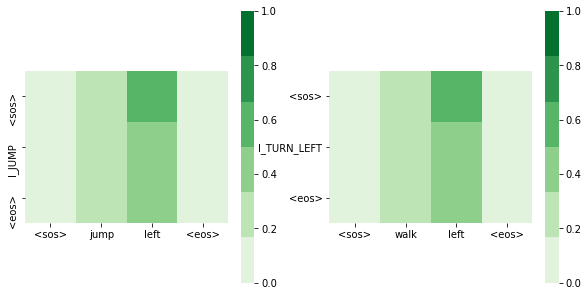

<sos> I_TURN_LEFT I_JUMP <eos> 	 <sos> I_TURN_LEFT I_WALK <eos>
Decoder Layer 2 Self Attention


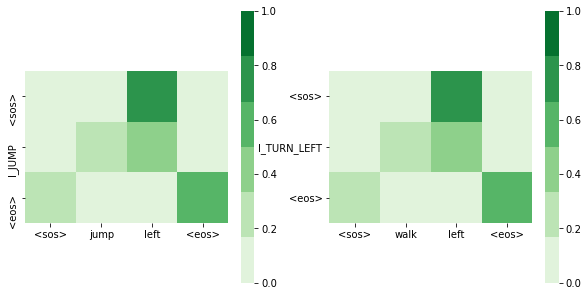

<sos> I_TURN_LEFT I_JUMP <eos> 	 <sos> I_TURN_LEFT I_WALK <eos>


In [66]:
for layer in range(2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f'Decoder Layer {layer + 1} Self Attention')
    for i in range(2):
        draw(torch.mean(dec_maps[layer].get('Sublayer2')[i], axis=0)[:len(predictions[i]), :len(ss[i])], ss[i], predictions[i], ax=axs[i])
    plt.show()
    print(trg_txt[0], '\t', trg_txt[1])

In [68]:
import torch
from models.tp_separate import EmbeddingMultilinearSinusoidal, Encoder, Decoder, Seq2Seq

embedding = EmbeddingMultilinearSinusoidal(d_vocab=18,
                                           d_x=256,
                                           d_r=256//8,
                                           dropout=0.1,
                                           max_length=200)

decoder = Decoder(
    d_x=256,
    d_q=256//8,
    d_k=256//8,
    d_v=256//8,
    d_f=512,
    use_xv=False,
    cat_xm=False,
    n_I=8,
    n_L=2,
    dropout=0.1
)

model = Seq2Seq(embedding=embedding,
               encoder=None,
               decoder=decoder,
               pad_idx=1,
               use_adversary=False,
               d_x=256,
               d_vocab=18,
               adv_lambda=0.01,
               adv_theta=0.01,
               adv_lr=0.01,
               skip_enc=True)

device = torch.device('cpu')
model.load_state_dict(torch.load('../weights/sep-transformer/scan/defaults_sep_enc_se_addjump.pt', map_location=device))
model = model.to(device)

In [69]:
pad_idx = 1
model.eval()
all_correct_trials = []
with torch.no_grad():
    trg_input = trg[:, :-1]
    trg_out = trg[:, 1:]
    trg_ann_input = trg_ann[:, :-1]
    out, adv_stat, attn_wt = model(src, trg_input, src_ann, trg_ann_input)
    pred = torch.argmax(out, axis=2)
    correct_pred = pred == trg_out
    correct_pred = correct_pred.cpu().numpy()
    mask = trg_out == pad_idx
    mask = mask.cpu().numpy()
    correct = np.logical_or(mask, correct_pred)
    correct = correct.all(0).tolist()
    all_correct_trials += correct
print(np.mean(all_correct_trials))

0.045454545454545456


In [70]:
predictions = []
preds_txt = []
for s in pred:
    prediction = '<sos> '
    for i in range(1, s.shape[0]):
        sym = TRG.vocab.itos[s[i]]
        if sym == '<eos>': break
        prediction += sym + ' '
    prediction += '<eos>'
    predictions.append(prediction.split())
    preds_txt.append(prediction)

In [71]:
preds_txt

['<sos> I_JUMP I_JUMP <eos>',
 '<sos> I_TURN_LEFT <eos>',
 '<sos> I_JUMP I_JUMP <eos>',
 '<sos> I_RUN I_RUN <eos>',
 '<sos> I_JUMP I_JUMP I_JUMP I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <eos>',
 '<sos> I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <eos>',
 '<sos> I_LOOK I_LOOK I_LOOK I_LOOK I_LOOK I_RUN I_LOOK I_RUN I_LOOK I_LOOK I_LOOK I_RUN I_LOOK I_RUN I_RUN I_RUN I_RUN I_RUN I_RUN I_RUN I_RUN <eos>',
 '<sos> I_LOOK I_LOOK I_LOOK I_LOOK I_LOOK I_LOOK I_LOOK I_RUN I_LOOK I_LOOK I_LOOK I_RUN I_LOOK I_RUN I_RUN I_RUN I_RUN I_RUN I_RUN I_RUN I_RUN <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_RUN I_RUN <eos>']

In [72]:
trg_txt

['<sos> I_TURN_LEFT I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_WALK <eos>',
 '<sos> I_JUMP I_JUMP <eos>',
 '<sos> I_WALK I_WALK <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_TURN_LEFT I_WALK <eos>',
 '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <eos>',
 '<sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <eos>',
 '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <eos>',
 '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <eos>',
 '<sos> I_TURN_L

Decoder Layer 1 Self Attention


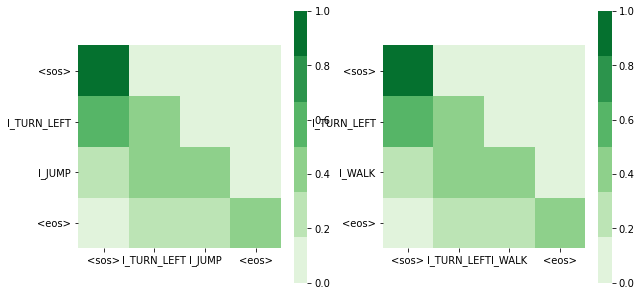

Decoder Layer 2 Self Attention


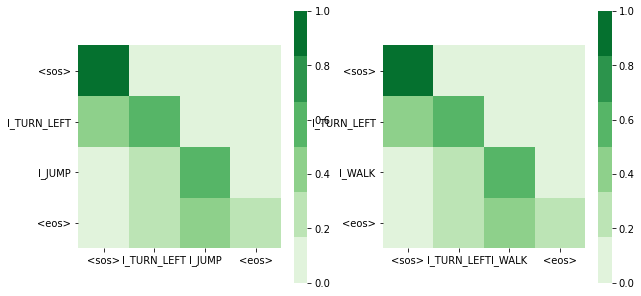

In [73]:
dec_maps = attn_wt.get('Decoder')
for layer in range(2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f'Decoder Layer {layer + 1} Self Attention')
    for i in range(2):
        draw(torch.mean(dec_maps[layer].get('Sublayer1')[i], axis=0)[:len(tt[i]), :len(tt[i])], tt[i], tt[i], ax=axs[i])
    plt.show()

Decoder Layer 1 Self Attention


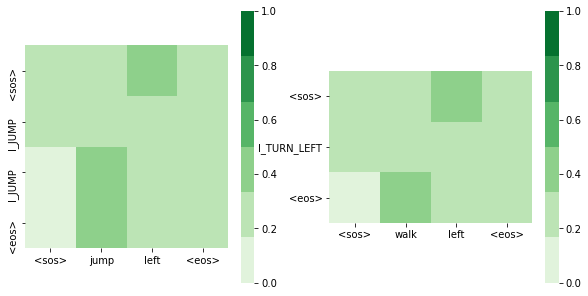

<sos> I_TURN_LEFT I_JUMP <eos> 	 <sos> I_TURN_LEFT I_WALK <eos>
Decoder Layer 2 Self Attention


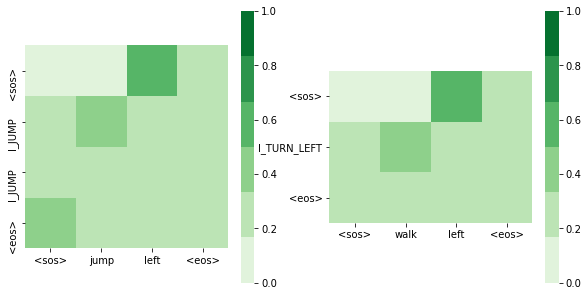

<sos> I_TURN_LEFT I_JUMP <eos> 	 <sos> I_TURN_LEFT I_WALK <eos>


In [74]:
for layer in range(2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f'Decoder Layer {layer + 1} Self Attention')
    for i in range(2):
        draw(torch.mean(dec_maps[layer].get('Sublayer2')[i], axis=0)[:len(predictions[i]), :len(ss[i])], ss[i], predictions[i], ax=axs[i])
    plt.show()
    print(trg_txt[0], '\t', trg_txt[1])